In this example I want to try to simulate an IIR filter in Python. This should help me to design IIR filters with migen and later with nmigen. Why should that help me? I want to test fixed point calculations here, which should then be used in migen and nmigen. The first part of code is just making an IIR Filter running.

Filter Coefs: coefa and coefb:
[ 1.         -1.96446058  0.96508117] [0.00015515 0.0003103  0.00015515]


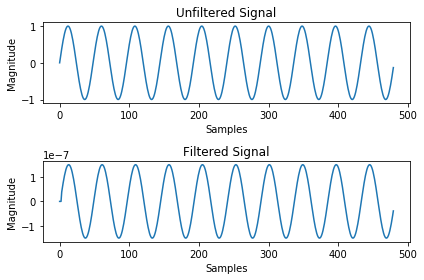

In [38]:
import matplotlib.pyplot as plt #For plotting
from math import sin, pi #For generating input signals
import sys #For reading command line arguments
import scipy.signal as sig
import numpy as np

### Filter - 6KHz->8Khz Bandpass Filter
### @param [in] input - input unfiltered signal
### @param [out] output - output filtered signal
def filter(x , coefb, coefa):
    y = [0]*48000
    for n in range(3, len(x)):
        y[n] = (coefb[0]*x[n] + coefb[1]*x[n-1]+  coefb[2]*x[n-2] -(coefa[1]*y[n-1] + coefa[2]*y[n-2]))/(2**Exp)
    return y

###Read in desired frequency from command line
#frequency = int(sys.argv[1])
frequency = 1000

## Create the filter
Fs = 5000           #Sample Frequ
sample = 5000       #Number of Samples
f = 100             #Sig gen Frequ
n = 2               #Order of Filter
rs = 30             #only for Cheby
fc = 20            #Cut Frequ
w_c = 2*fc/Fs       #Digital Frequ -> 0 - 0.5
Exp = 12
[coefb,coefa] = sig.iirfilter(n,w_c ,0,rs, btype="lowpass", analog=False, ftype="butter")
print("Filter Coefs: coefa and coefb:")
print(coefa,coefb)


### Create empty arrays
input = [0]*48000
output = [0]*48000

### Fill array with xxxHz signal
for i in range(48000):
    input[i] = sin(2 * pi * frequency * i / 48000) #+ sin(2 * pi * 70 * i / 48000)

### Run the signal through the filter
output = filter(input,coefb,coefa)

### Grab samples from input and output #1/100th of a second
output_section = output[0:480]
input_section = input[0:480]

### Plot the signals for comparison
plt.figure(1)
plt.subplot(211)
plt.ylabel('Magnitude')
plt.xlabel('Samples')
plt.title('Unfiltered Signal')
plt.plot(input_section)
plt.subplot(212)
plt.ylabel('Magnitude')
plt.xlabel('Samples')
plt.title('Filtered Signal')
plt.plot(output_section)
plt.tight_layout()
plt.show()


Here it is easy to see that a IIR Filter does a pretty awesome Job. A 100Hz signal which is given to a second order IIR filter with a cutoff frequency of 20 Hz is cuted down to a Amplitude with the size of 1*10^-7.


In the next example I try to change this code to see how bad the result gets when I sample with 16 bits. I try manually to avoid an overflow. So basically I multiply my code with a factor and compare the floatingpoint results from above with the fixpoint results.
In the following code I use a Faktor of 13.
Why 13?
Because the biggest absolute number of the filter polynoms is -1.96446058
I need one bit for the sign.
I need at least two bits for the integer part of the number.
16-1-2 = 13
The next problem ist the samllest number of the filter Polynom: 0.00015515
It must be secured that this polynom gives at least 1 after the "quantisation" of problems might accure later.
0.00015515 * 2^13 = 1.27... -> this is fine


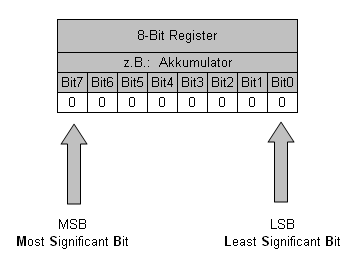

In [39]:
from IPython.display import Image
Image("img/SB_LSB_8bit.gif")

old coefa and coefb:
[ 1.         -1.96446058  0.96508117] [0.00015515 0.0003103  0.00015515]
new coefa and coefb:
[  8192. -16092.   7905.] [1. 2. 1.]
<class 'numpy.int16'>
-0b11111011011100


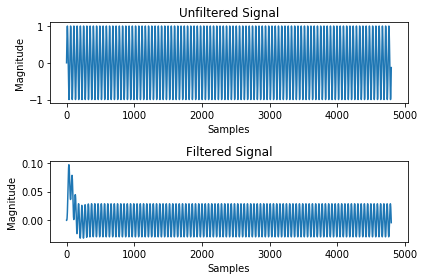

In [40]:
import matplotlib.pyplot as plt #For plotting
from math import sin, pi #For generating input signals
import sys #For reading command line arguments
import scipy.signal as sig
import numpy as np

### Filter - 6KHz->8Khz Bandpass Filter
### @param [in] input - input unfiltered signal
### @param [out] output - output filtered signal
def filter(x , coefb, coefa):
    y = [0]*48000
    for n in range(3, len(x)):
        y[n] = (coefb[0]*x[n] + coefb[1]*x[n-1]+  coefb[2]*x[n-2] -(coefa[1]*y[n-1] + coefa[2]*y[n-2]))/(2**Exp)
    return y

###Read in desired frequency from command line
#frequency = int(sys.argv[1])
frequency = 1000

## Create the filter
Fs = 5000           #Sample Frequ
sample = 5000       #Number of Samples
f = 100             #Sig gen Frequ
n = 2               #Order of Filter
rs = 30             #only for Cheby
fc = 20            #Cut Frequ
w_c = 2*fc/Fs       #Digital Frequ -> 0 - 0.5
Exp = 13
[coefb,coefa] = sig.iirfilter(n,w_c ,0,rs, btype="lowpass", analog=False, ftype="butter")

###Used to do test for the needed Exponent
print("old coefa and coefb:")
print(coefa,coefb)
i=0
for c in coefa:
    coefa[i] = np.int16(coefa[i]*2**Exp)        #Takes the Coeficients an multiplys it with 2**Exp then cuts the fract bits
    i=i+1
i=0
for c in coefb:
    coefb[i] = int(coefb[i]*2**Exp)        #Takes the Coeficients an multiplys it with 2**Exp then cuts the fract bits
    i=i+1
print("new coefa and coefb:")
print(coefa,coefb)
coefa = coefa.astype('int16')
print(type(coefa[0]))
print(bin(coefa[1]))
###########################################


### Create empty arrays
input = [0]*48000
output = [0]*48000

### Fill array with xxxHz signal
for i in range(48000):
    input[i] = sin(2 * pi * frequency * i / 48000) #+ sin(2 * pi * 70 * i / 48000)

### Run the signal through the filter
output = filter(input,coefb,coefa)

### Grab samples from input and output #1/100th of a second
output_section = output[0:4800]
input_section = input[0:4800]

### Plot the signals for comparison
plt.figure(1)
plt.subplot(211)
plt.ylabel('Magnitude')
plt.xlabel('Samples')
plt.title('Unfiltered Signal')
plt.plot(input_section)
plt.subplot(212)
plt.ylabel('Magnitude')
plt.xlabel('Samples')
plt.title('Filtered Signal')
plt.plot(output_section)
plt.tight_layout()
plt.show()
